# Regression with confidence interval

The notebook computes confidence intervals with [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) and [quantile regression](https://en.wikipedia.org/wiki/Quantile_regression) on a simple problem.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter("ignore")

## Some data

The data follows the formula: $y = \frac{X}{2} + 2 + \epsilon_1 + \eta \epsilon_2$. Noises follows the laws $\epsilon_1 \sim \mathcal{N}(0, 0.2)$, $\epsilon_2 \sim \mathcal{N}(1, 1)$, $\eta \sim \mathcal{B}(2, 0.0.5)$. The second part of the noise adds some bigger noise but not always.

In [4]:
from numpy.random import randn, binomial, rand
N = 200
X = rand(N, 1) * 2
eps = randn(N, 1) * 0.2
eps2 = randn(N, 1) + 1
bin = binomial(2, 0.05, size=(N, 1))
y = (0.5 * X + eps + 2 + eps2 * bin).ravel()

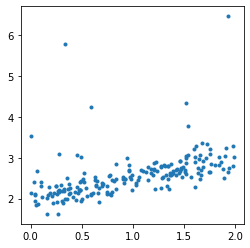

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(X, y, '.');

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Confidence interval with a linear regression

The object fits many times the same learner, every training is done on a resampling of the training dataset.

In [7]:
from mlinsights.mlmodel import IntervalRegressor
from sklearn.linear_model import LinearRegression

lin = IntervalRegressor(LinearRegression())
lin.fit(X_train, y_train)

IntervalRegressor(estimator=LinearRegression())

In [8]:
import numpy
sorted_X = numpy.array(list(sorted(X_test)))
pred = lin.predict(sorted_X)
bootstrapped_pred = lin.predict_sorted(sorted_X)
min_pred = bootstrapped_pred[:, 0]
max_pred = bootstrapped_pred[:, bootstrapped_pred.shape[1]-1]

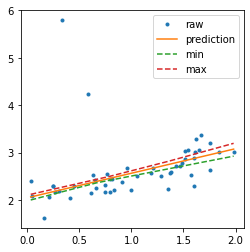

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(X_test, y_test, '.', label="raw")
ax.plot(sorted_X, pred, label="prediction")
ax.plot(sorted_X, min_pred, '--', label="min")
ax.plot(sorted_X, max_pred, '--', label="max")
ax.legend();

## Higher confidence interval

It is possible to use smaller resample of the training dataset or we can increase the number of resamplings.

In [10]:
lin2 = IntervalRegressor(LinearRegression(), alpha=0.3)
lin2.fit(X_train, y_train)

IntervalRegressor(alpha=0.3, estimator=LinearRegression())

In [11]:
lin3 = IntervalRegressor(LinearRegression(), n_estimators=50)
lin3.fit(X_train, y_train)

IntervalRegressor(estimator=LinearRegression(), n_estimators=50)

In [12]:
pred2 = lin2.predict(sorted_X)
bootstrapped_pred2 = lin2.predict_sorted(sorted_X)
min_pred2 = bootstrapped_pred2[:, 0]
max_pred2 = bootstrapped_pred2[:, bootstrapped_pred2.shape[1]-1]

In [13]:
pred3 = lin3.predict(sorted_X)
bootstrapped_pred3 = lin3.predict_sorted(sorted_X)
min_pred3 = bootstrapped_pred3[:, 0]
max_pred3 = bootstrapped_pred3[:, bootstrapped_pred3.shape[1]-1]

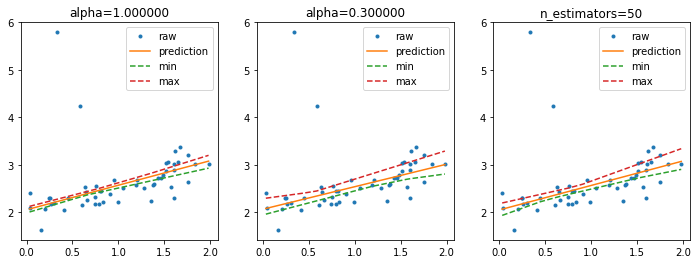

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(X_test, y_test, '.', label="raw")
ax[0].plot(sorted_X, pred, label="prediction")
ax[0].plot(sorted_X, min_pred, '--', label="min")
ax[0].plot(sorted_X, max_pred, '--', label="max")
ax[0].legend()
ax[0].set_title("alpha=%f" % lin.alpha)
ax[1].plot(X_test, y_test, '.', label="raw")
ax[1].plot(sorted_X, pred2, label="prediction")
ax[1].plot(sorted_X, min_pred2, '--', label="min")
ax[1].plot(sorted_X, max_pred2, '--', label="max")
ax[1].set_title("alpha=%f" % lin2.alpha)
ax[1].legend()
ax[2].plot(X_test, y_test, '.', label="raw")
ax[2].plot(sorted_X, pred3, label="prediction")
ax[2].plot(sorted_X, min_pred3, '--', label="min")
ax[2].plot(sorted_X, max_pred3, '--', label="max")
ax[2].set_title("n_estimators=%d" % lin3.n_estimators)
ax[2].legend();

## With decision trees

In [15]:
from sklearn.tree import DecisionTreeRegressor
tree = IntervalRegressor(DecisionTreeRegressor(min_samples_leaf=10))
tree.fit(X_train, y_train)

IntervalRegressor(estimator=DecisionTreeRegressor(min_samples_leaf=10))

In [16]:
pred_tree = tree.predict(sorted_X)
b_pred_tree = tree.predict_sorted(sorted_X)
min_pred_tree = b_pred_tree[:, 0]
max_pred_tree = b_pred_tree[:, b_pred_tree.shape[1]-1]

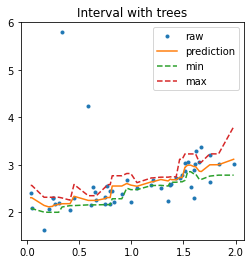

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(X_test, y_test, '.', label="raw")
ax.plot(sorted_X, pred_tree, label="prediction")
ax.plot(sorted_X, min_pred_tree, '--', label="min")
ax.plot(sorted_X, max_pred_tree, '--', label="max")
ax.set_title("Interval with trees")
ax.legend();

In that case, the prediction is very similar to the one a random forest would produce as it is an average of the predictions made by 10 trees.

## Regression quantile

The last way tries to fit two regressions for quantiles 0.05 and 0.95.

In [18]:
from mlinsights.mlmodel import QuantileLinearRegression
m = QuantileLinearRegression()
q1 = QuantileLinearRegression(quantile=0.05)
q2 = QuantileLinearRegression(quantile=0.95)
for model in [m, q1, q2]:
    model.fit(X_train, y_train)

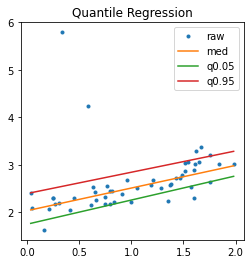

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(X_test, y_test, '.', label="raw")

for label, model in [('med', m), ('q0.05', q1), ('q0.95', q2)]:
    p = model.predict(sorted_X)
    ax.plot(sorted_X, p, label=label)
ax.set_title("Quantile Regression")
ax.legend();

With a non linear model... but the model *QuantileMLPRegressor* only implements the regression with quantile 0.5.

## With seaborn

It uses a theoritical way to compute the confidence interval by computing the confidence interval on the parameters first.

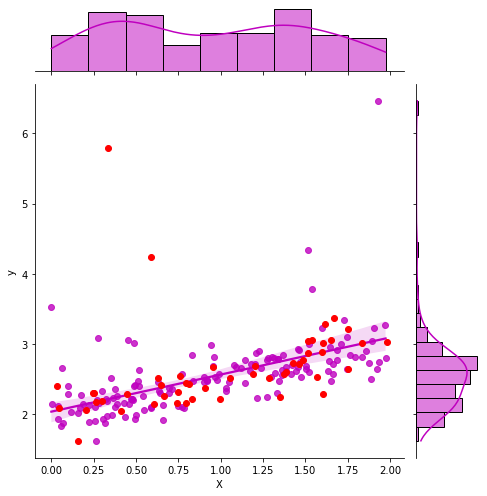

In [20]:
import seaborn as sns
import pandas

df_train = pandas.DataFrame(dict(X=X_train.ravel(), y=y_train))
g = sns.jointplot("X", "y", data=df_train, kind="reg", color="m", height=7)
g.ax_joint.plot(X_test, y_test, 'ro');

## GaussianProcessRegressor

Last option with this example [Gaussian Processes regression: basic introductory example](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html) which computes the standard deviation for every prediction. It can then be used to show an interval confidence.

In [21]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, DotProduct, WhiteKernel

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=9)

In [22]:
y_pred, sigma = gp.predict(sorted_X, return_std=True)

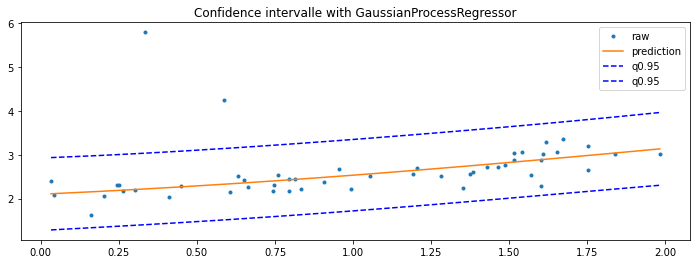

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(X_test, y_test, '.', label="raw")
ax.plot(sorted_X, y_pred, label="prediction")
ax.plot(sorted_X, y_pred + sigma * 1.96, 'b--', label="q0.95")
ax.plot(sorted_X, y_pred - sigma * 1.96, 'b--', label="q0.95")
ax.set_title("Confidence intervalle with GaussianProcessRegressor")
ax.legend();